## Load Package

In [24]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import stockstats
import scipy
from scipy.optimize import fmin_l_bfgs_b

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

## Create Sine and Cosine as tow stock prices

In [25]:
x = np.linspace(0,2*np.pi, 100)
tic1 = np.sin(x) + 3
tic2 = np.cos(x) + 2.6
np.random.seed(66)
noise1 = np.random.normal(loc=0., scale=0.2, size=100)
noise2 = np.random.normal(loc=0., scale=0.2, size=100)
tic1 += noise1
tic2 += noise2

prices = pd.DataFrame([tic1, tic2], index=['A', 'B']).T
returns = prices.pct_change().fillna(method='bfill')

universe = prices.stack().reset_index()
universe.columns = ['time', 'ticker', 'close']
universe['time'] = universe['time'] + 1
universe['returns'] = returns.stack().values
universe['high'] = universe['close'] + np.random.uniform(0.01,0.2,200)
universe['low'] = universe['close'] - np.random.uniform(0.01,0.2,200)

universe.head()

,time,ticker,close,returns,high,low
0,1,A,3.283123,-0.133031,3.443360,3.132449
1,1,B,3.581084,-0.014113,3.712382,3.548906
2,2,A,2.846367,-0.133031,3.008649,2.798132
3,2,B,3.530543,-0.014113,3.561684,3.502521
4,3,A,3.003331,0.055145,3.089727,2.974724


<AxesSubplot:>

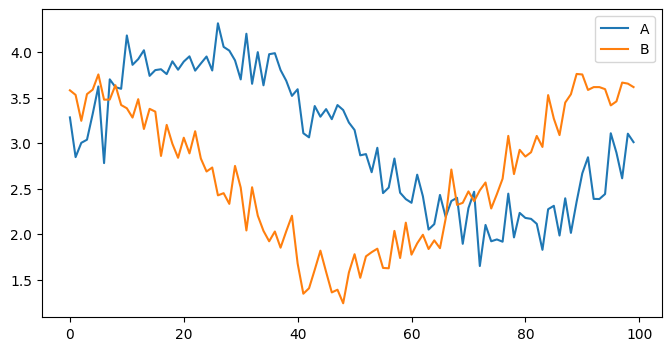

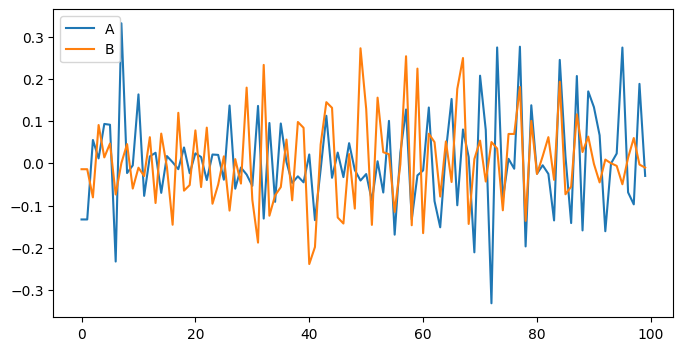

In [26]:
prices.plot()
returns.plot()
#universe.loc[universe.ticker=='A'][['high','low']].plot()
#universe.loc[universe.ticker=='B'][['high','low']].plot()

## shift return 2 times
In oder to animate stocke market, since we calculate strategy from end of day and trading next day, so that realize return delay 2 days. In this notebook, we delay returns two times.

In [27]:
universe['returns_2'] = universe['returns'].shift(-4).fillna(method='ffill')
universe.head()

,time,ticker,close,returns,high,low,returns_2
0,1,A,3.283123,-0.133031,3.443360,3.132449,0.055145
1,1,B,3.581084,-0.014113,3.712382,3.548906,-0.080752
2,2,A,2.846367,-0.133031,3.008649,2.798132,0.011500
3,2,B,3.530543,-0.014113,3.561684,3.502521,0.090496
4,3,A,3.003331,0.055145,3.089727,2.974724,0.093055


## Make Alpha Factors

###  alpha_factor1
Simple and best alpha factor for sine and consine is their dirivate function. Indeed, sine and cosine is an exposure of factor pi.

In [28]:
ticker_names = ['A', 'B']
factor_tmp = pd.DataFrame()
for ticker in ticker_names:
    universe_i = universe.loc[universe.ticker==ticker][['time','ticker']]
    universe_i['pi_factor'] = x
    if ticker == 'A':
        universe_i['alpha1'] = np.cos(x)
    else:
        universe_i['alpha1'] = -np.sin(x)
    factor_tmp = factor_tmp.append(universe_i)
    
universe = universe.merge(factor_tmp, on=['time', 'ticker'], how='left')

### alpha_factor2
Try SuperTrend indicator which create by stockstats. We use it compare to prices

In [29]:
tech_indicator_list = ['supertrend_ub', 'supertrend_lb', 'supertrend', 'close_5_sma']
stockstats.StockDataFrame.SUPERTREND_MUL = 2 #default = 3
stockstats.StockDataFrame.SUPERTREND_WINDOW = 5 #default=14
stocks = stockstats.StockDataFrame.retype(universe)
unique_ticker = universe.ticker.unique()
indicator_df = pd.DataFrame()
for i in tqdm(range(len(unique_ticker)), desc='add tech indicators'):
    temp_indicator = stocks[stocks.ticker == unique_ticker[i]][tech_indicator_list]
    temp_indicator = pd.DataFrame(temp_indicator)
    temp_indicator["ticker"] = unique_ticker[i]
    temp_indicator[["time","close"]] = stocks.loc[stocks.ticker == unique_ticker[i]][["time","close"]]
    #temp_indicator.fillna(method='backfill', inplace=True)
    #trend_up = temp_indicator['supertrend_ub'] - temp_indicator['close']
    #trend_down = temp_indicator['close'] - temp_indicator['supertrend_lb']
    #temp_indicator['alpha2'] = -np.where(trend_up>0, trend_up, np.where(trend_down<0, trend_down, 0))
    temp_indicator['alpha2'] = temp_indicator['close_5_sma'] - temp_indicator['supertrend']
    indicator_df = indicator_df.append(temp_indicator, ignore_index=True)
    
universe = universe.merge(indicator_df[["time", "ticker","alpha2",'supertrend_ub', 'supertrend_lb', 'supertrend']],
                          on=["time", "ticker"], how="left")
universe = universe.sort_values(by=["time", "ticker"])

add tech indicators: 100%|████████████████████████| 2/2 [00:00<00:00, 34.94it/s]


<AxesSubplot:>

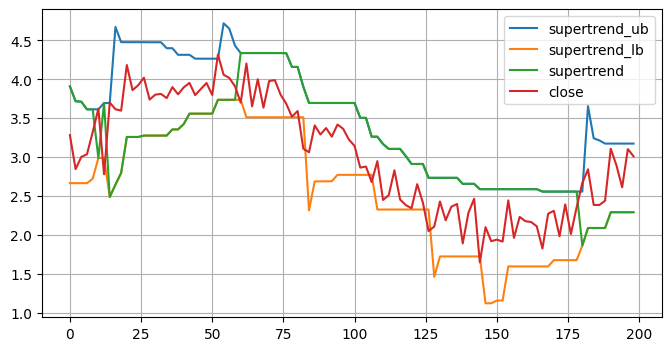

In [30]:
universe[['supertrend_ub', 'supertrend_lb', 'supertrend','close']].loc[universe.ticker=='A'].plot(grid=True)

In [31]:
universe.head()

,time,ticker,close,returns,high,low,returns_2,pi_factor,alpha1,alpha2,supertrend_ub,supertrend_lb,supertrend
0,1,A,3.283123,-0.133031,3.443360,3.132449,0.055145,0.000000,1.000000,-0.626603,3.909725,2.666084,3.909725
1,1,B,3.581084,-0.014113,3.712382,3.548906,-0.080752,0.000000,-0.000000,-0.376512,3.957596,3.303693,3.957596
2,2,A,2.846367,-0.133031,3.008649,2.798132,0.011500,0.063467,0.997987,-0.653889,3.718634,2.666084,3.718634
3,2,B,3.530543,-0.014113,3.561684,3.502521,0.090496,0.063467,-0.063424,-0.208893,3.764707,3.303693,3.764707
4,3,A,3.003331,0.055145,3.089727,2.974724,0.093055,0.126933,0.991955,-0.668555,3.712828,2.666084,3.712828


<AxesSubplot:xlabel='time'>

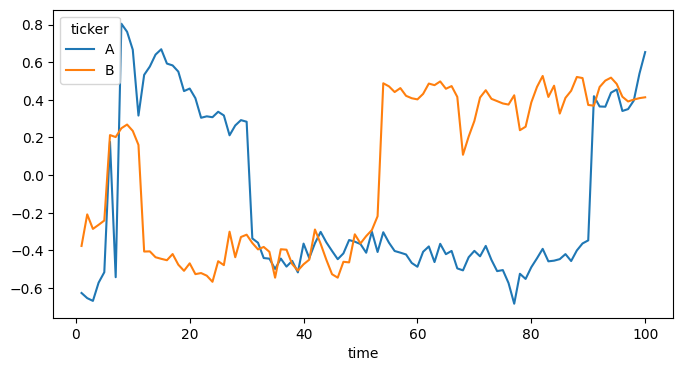

In [32]:
universe.pivot(index='time', columns='ticker', values='alpha2').plot()
#universe.pivot(index='time', columns='ticker', values='alpha1').plot()

## PCA risk model

In [33]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, ann_factor, num_factor_exposures):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, 
                                            self.factor_returns_, self.factor_betas_, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, factor_returns, factor_betas, ann_factor):
        estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_);

### alpha_factor3
Use residual_risk calculate by PCA as a factor. PCA rolling window 10 times

In [34]:
def factor3(returns_df, ):
    # Set the year factor
    ann_factor = 20
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 1
    # Create a RiskModel object
    rm = RiskModel(returns_df, ann_factor, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    f = rm.factor_returns_
    
    # temperaory set all equal weights
    universe_tickers = universe.ticker.unique()
    variance = np.dot(B, F).dot(B.T) + S
    
    return variance, B, f, rm.idiosyncratic_var_vector

variance_all = {}
returns_df = universe.pivot(index='time', columns='ticker', values='returns').fillna(0)
residual_df = pd.DataFrame()

for ii, obj_i in enumerate(returns_df.rolling(window=10),1):
    variance_i, B, risk_factor, residual_i = factor3(obj_i)
    variance_all[ii] = [variance_i, B, risk_factor.sum()]
    residual_i['time'] = ii
    residual_df = residual_df.append(residual_i)
    
residual_df.reset_index(inplace=True)
residual_df.columns = ['ticker', 'residual', 'time']
residual_df['alpha3'] = np.where(residual_df['residual']<1e-4, residual_df['residual'].median(), residual_df['residual'])
# index 0 is nan df
variance_all[1][0] = variance_all[2][0]
universe = universe.merge(residual_df, on=['time','ticker'], how='left')
universe.head()

,time,ticker,close,returns,high,low,returns_2,pi_factor,alpha1,alpha2,supertrend_ub,supertrend_lb,supertrend,residual,alpha3
0,1,A,3.283123,-0.133031,3.443360,3.132449,0.055145,0.000000,1.000000,-0.626603,3.909725,2.666084,3.909725,0.000000e+00,0.016237
1,1,B,3.581084,-0.014113,3.712382,3.548906,-0.080752,0.000000,-0.000000,-0.376512,3.957596,3.303693,3.957596,0.000000e+00,0.016237
2,2,A,2.846367,-0.133031,3.008649,2.798132,0.011500,0.063467,0.997987,-0.653889,3.718634,2.666084,3.718634,0.000000e+00,0.016237
3,2,B,3.530543,-0.014113,3.561684,3.502521,0.090496,0.063467,-0.063424,-0.208893,3.764707,3.303693,3.764707,0.000000e+00,0.016237
4,3,A,3.003331,0.055145,3.089727,2.974724,0.093055,0.126933,0.991955,-0.668555,3.712828,2.666084,3.712828,1.283953e-33,0.016237


In [35]:
print(variance_all[99][0])
print(variance_all[99][1])
print(variance_all[99][2], type(variance_all[99][2]))

ticker         A         B
ticker                    
A       0.387207 -0.040053
B      -0.040053  0.024858
          0
A  0.994687
B -0.102949
0    8.326673e-17
dtype: float64 <class 'pandas.core.series.Series'>


## Factor Exposures and Factor Returns

Recall that:

$r_{i,t} = \sum_{j=1}^{k} (\beta_{i,j,t-2} \times f_{j,t})$  
where $i=1...N$ (N assets),   
and $j=1...k$ (k factors).

where $r_{i,t}$ is the return, $\beta_{i,j,t-2}$ is the factor exposure, and $f_{j,t}$ is the factor return. Since we get the factor exposures from the our factors, and we know the returns, it is possible to estimate the factor returns. In this notebook, we will use the Ordinary Least Squares (OLS) method to estimate the factor exposures, $f_{j,t}$, by using $\beta_{i,j,t-2}$ as the independent variable, and $r_{i,t}$ as the dependent variable.

In [36]:
from statistics import median
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols

def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def density_plot(data): 
    # data is series
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .2
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.xlabel('times Returns')
    plt.ylabel('Density')
    plt.show()

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.25, 0.25)
    all_factors = factors_from_names(list(df), name)
    form = get_formula(all_factors, "returns_2")
    model = ols(form, data=estu)
    results = model.fit()
    return results

estimate_factor_returns(universe.loc[universe.time==39]).params

alpha1   -1.580359
alpha2    2.642056
alpha3    3.476456
dtype: float64

In [37]:
from scipy.stats import zscore
alpha_df_f = universe[['alpha1','alpha2','alpha3','time','ticker']].set_index(['time', 'ticker'])
alpha_df_f = alpha_df_f.apply(zscore).reset_index()
alpha_df_f['returns_2'] = universe['returns_2']
facret = {}
for ii in range(1,101):
    facret[ii] = estimate_factor_returns(alpha_df_f.loc[universe.time==ii]).params
facret[98]

alpha1   -0.014003
alpha2   -0.005420
alpha3    0.006134
dtype: float64

As we calculated each factor, take a view if each factor correspond to accumulate return

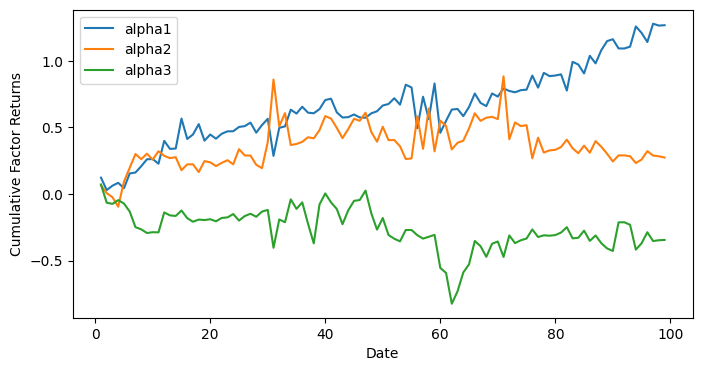

In [38]:
alpha_factors = ["alpha1", "alpha2", "alpha3"]

my_times = range(1,100)
facret_df = pd.DataFrame(index = my_times)

for dt in my_times: 
    for alp in alpha_factors: 
        facret_df.at[dt, alp] = facret[dt][alp]

for column in facret_df.columns:
    plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

Due to we know the future ticker price graph, we can take a view each factor exposure graph to understand their performance

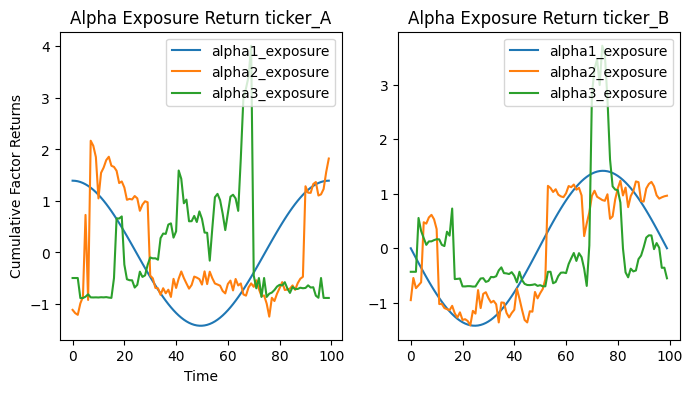

In [39]:
fig = plt.figure(figsize=(8,4))
alpha_df = alpha_df_f.drop(columns=['returns_2']).set_index(['time', 'ticker'])
plot_df = alpha_df.loc[alpha_df.index.get_level_values(1)=='A']
for column in alpha_df.columns[:3]: 
    plt.subplot(1, 2, 1)
    plt.plot(plot_df.apply(zscore)[column].values, label=column+'_exposure')

plt.title('Alpha Exposure Return ticker_A')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Cumulative Factor Returns')

plot_df = alpha_df.loc[alpha_df.index.get_level_values(1)=='B']
for column in alpha_df.columns[:3]: 
    plt.subplot(1, 2, 2)
    plt.plot(plot_df.apply(zscore)[column].values, label=column+'_exposure')
plt.title('Alpha Exposure Return ticker_B')
plt.legend(loc='upper right')
plt.show()

## Combine All Alpha
This project just show an example of bactesting process so I we can sum alpha factors by multiply weight.
Because of we know alpha1 performance is best, so assignment alpha2 larger weight to test its performance .

after combine alpha factor we need to nomalize factor to percent expressed

1.5320817173024788 -1.2249863315452565


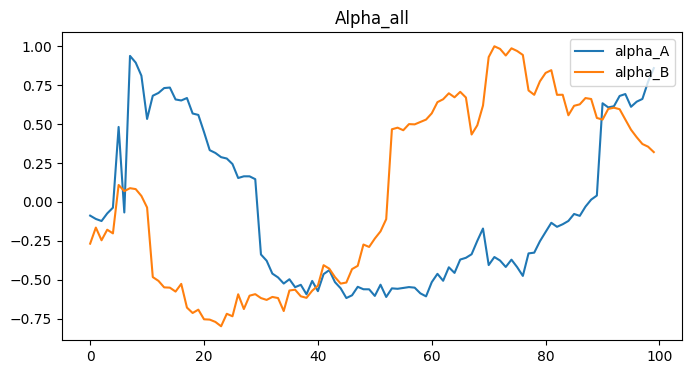

In [40]:
alpha_df['alpha_all'] = (0.4*alpha_df['alpha1'] + 0.5*alpha_df['alpha2'] + 0.1*alpha_df['alpha3'])
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))
alpha_df['alpha_all'] = alpha_df['alpha_all']/max(alpha_df['alpha_all'])

plot_df = alpha_df.loc[alpha_df.index.get_level_values(1)=='A']
plt.plot(plot_df['alpha_all'].values, label='alpha_A')
plot_df = alpha_df.loc[alpha_df.index.get_level_values(1)=='B']
plt.plot(plot_df['alpha_all'].values, label='alpha_B')
plt.title('Alpha_all')
plt.legend(loc='upper right')
plt.show()

# Backtesting
We can optimize portfolio positions each time by `fmin_l_bfgs_b` function.
If we use h as money unit directly. we need to set some parameter below.

## Risk Aversion parameter

The risk aversion term is set to target a particular gross market value (GMV), or to target a desired volatility.  

The gross market value is the dollar value of the absolute value of the long and short positions.

$ GMV = \sum_i^N(|h_{i,t}|)$

$ Loss_{endure} = aversion * GMV $ where loss is investor endure in all GMV

Also, in practice, you'd normally keep the risk aversion term constant, unless your fund is accepting more investor cash, or handling redemptions.  In those instances, the fund size itself changes, so the targeted GMV also changes.  Therefore, we'd adjust the risk aversion term to adjust for the desired GMV. 

Also, note that we would keep this risk aversion term constant, and not adjust it on a daily basis.  Adjusting the risk aversion term too often would result in unnecessary trading that isn't informed by the alphas.

## Linear price impact of trading
$\%  \Delta price_{i,t} = \lambda_{i,t} \times (h_{i,t} - h_{i,t-1})$ where $\lambda_{i,t} = 10^{-1}\times \frac{1}{ADV_{i,t}} = \frac{1}{10 \times ADV_{i,t}}$

$ADV_{i,t}$: (average dollar volume) is total dollar or percent amount expected to be traded, based on a moving average of historical daily volume.

$tcost_{t} = \sum_i^{N} \lambda_{i,t} (h_{i,t} - h_{i,t-1})^2$  
where $\lambda_{i,t} = \frac{1}{10\times ADV_{i,t}}$

In [41]:
# the lambda expressed a transfer costs can't endure, the larger the more we reject.
def get_obj_func(h0, variance, alpha, Lambda=1/(100 * 1.), aversion=.2): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + Lambda * (h-h0)
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=1/(100 * 1.), aversion=.2):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  aversion * np.dot(variance, h) - aversion * alpha + Lambda
        return f_hat
    return grad_func

In [42]:
# bounds means position bounds at each row. Here I only trade for long so that bounds from 0 to 1
#h0 = frame[1]['h_privious'].values
positions = {}
h0 = np.array([0.,0.])
bounds = [(0,1)]*2
for i in range(1,100+1):
    obj_df = alpha_df.loc[alpha_df.index.get_level_values(0)==i] 
    #obj_df['alpha_all'] = obj_df.apply(zscore)['alpha_all']
    obj_func = get_obj_func(h0, variance_all[i][0], obj_df['alpha_all'].values)
    grad_func = get_grad_func(h0, variance_all[i][0], obj_df['alpha_all'].values)
    h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
    #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
    
    obj_df['h_opt'] = h_optimal
    obj_df['h_privious'] = h0
    positions[i]= obj_df
    h0 = h_optimal
positions[100]

alpha1    alpha2    alpha3  alpha_all  h_opt  h_privious
time ticker                                                            
100  A       1.407178  1.660182 -0.762692   0.859414    1.0         1.0
     B      -0.007071  1.103483 -0.588201   0.319887    1.0         1.0

In [43]:
h_optimal_list = [positions[i]['h_opt'] for i in range(1, 100+1) ]
h_privious_list = [positions[i]['h_privious'] for i in range(1, 100+1) ]

## Calculate Exposure and Transaction Costs

### risk exposure
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}>

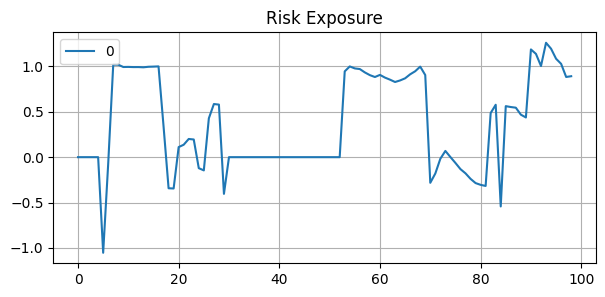

In [44]:
plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii in range(1,100):
    B = variance_all[ii][1]
    h_opt_i = h_privious_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[ii] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df

### alpha exposure

<AxesSubplot:>

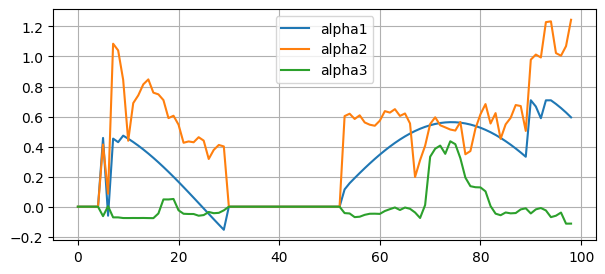

In [47]:
import patsy
import pandas
def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(universe[['time','ticker','returns_2']], on=['time','ticker'], how='left')
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for ii in range(1,100):
    alpha_df_i = alpha_df_.loc[alpha_df_.time==ii][['time','ticker','alpha1', 'alpha2', 'alpha3' ,'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    # divide 2 almost close to max(alpha_df['alpha_all'])
    B_alpha = B_alpha * [[0.4, 0.5, 0.1],[0.4, 0.5, 0.1]]
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=['alpha1', 'alpha2', 'alpha3'])
    alpha_exposures[ii] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.plot(grid=True)

In [48]:
transaction_costs = []
Lambda = 1/(100 * 1.)
for i in range(100):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    costs = sum(np.dot(tmp_change.values**2, Lambda))
    transaction_costs.append(costs)
print(sum(transaction_costs))

0.05982484478777219


## Profit-and-Loss (PnL) 

Profit and Loss is the aggregate realized time returns of the assets, weighted by the optimal portfolio holdings chosen, and summed up to get the portfolio's profit and loss.

The PnL attributed to the alpha factors equals the factor returns times factor exposures for the alpha factors.  

$$
\mbox{PnL}_{alpha}= f \times b_{alpha}
$$

Similarly, the PnL attributed to the risk factors equals the factor returns times factor exposures of the risk factors.

$$
\mbox{PnL}_{risk} = f \times b_{risk}
$$

In the code below, in the function `build_pnl_attribution` calculate the PnL attributed to the alpha factors, the PnL attributed to the risk factors, and attribution to cost. 

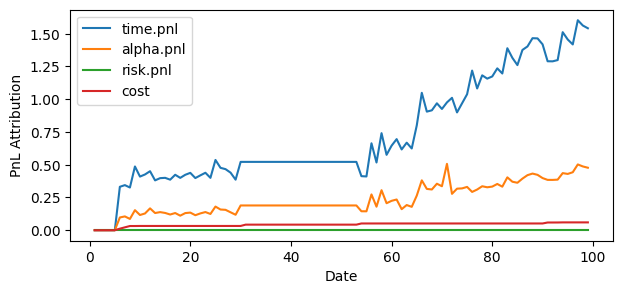

In [49]:
## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = range(1,100))
    
    for ii in range(1,100):
        p = positions[ii]
        #fr = facret_alpha_all[ii]
        fr = facret[ii] 
        rr = variance_all[ii][2]
        row_universe = universe.loc[universe.time==(ii)]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ticker', 'returns_2']], how = 'left', on = "ticker")  
        mf['returns_2'] = wins(mf['returns_2'], -0.5, 0.5)
        df.at[ii,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[ii,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[ii])
        df.at[ii,"risk.pnl"] = partial_dot_product(rr, risk_exposures[ii])
        alpha_exposure_df
        df.at[ii,"cost"] = transaction_costs[ii-1]
    return df

attr = build_pnl_attribution()
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

### View price and optimized position

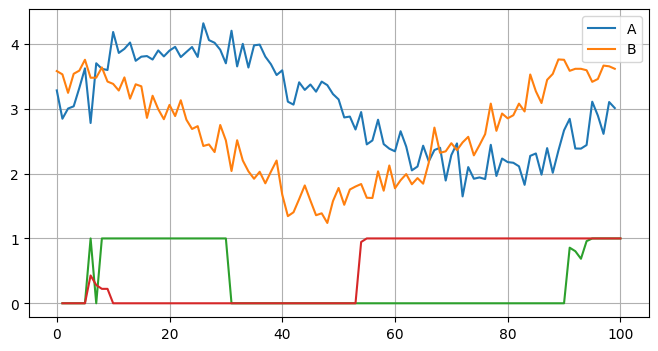

In [50]:
plt.rcParams['figure.figsize'] = [8, 4]
prices.plot(grid=True)
plt.plot(range(1, 100+1), h_optimal_list)

In [51]:
positions[80]

alpha1    alpha2    alpha3  alpha_all  h_opt  h_privious
time ticker                                                            
80   A       0.412848 -0.989011 -0.583801  -0.253085    0.0         0.0
     B       1.343398  1.039921  1.297096   0.774782    1.0         1.0

## Build portfolio characteristics
Calculate the sum of long positions, short positions, net positions, gross market value, and amount of dollars traded.

In the code below, in the function `build_portfolio_characteristics` calculate the sum of long positions, short positions, net positions, gross market value, and amount of dollars traded.  

In [52]:
def build_portfolio_characteristics(): 
    df = pd.DataFrame(index = range(1,100))
    
    for ii in range(1,100):
        p = positions[ii]

        df.at[ii,"long"] = np.sum([_ for _ in p['h_opt'] if _ > 0])
        # df.at[dt,"short"] = np.sum([_ for _ in h if _ < 0])
        df.at[ii,"net"] = np.sum(p['h_opt'])
        df.at[ii,"gmv"] = np.sum(abs(p['h_opt']))
        df.at[ii,"traded"] = np.sum(abs(p['h_opt'] - p['h_privious']))
        
    return df

    long  net  gmv    traded
95   2.0  2.0  2.0  0.041392
96   2.0  2.0  2.0  0.000000
97   2.0  2.0  2.0  0.000000
98   2.0  2.0  2.0  0.000000
99   2.0  2.0  2.0  0.000000


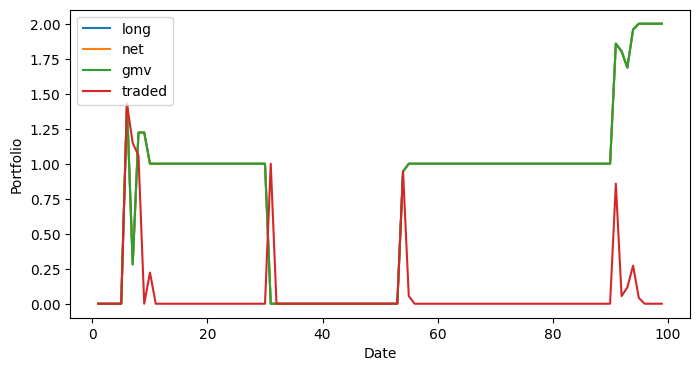

In [54]:
pchar = build_portfolio_characteristics()
print(pchar.tail())
for column in pchar.columns:
        plt.plot(pchar[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.show()